In [18]:
!pip install transformers datasets
!pip install --upgrade accelerate
!pip install transformers[torch]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.666800,0.710609,0.440000,0.440000,1.000000,0.611111
2,0.587900,0.636834,0.700000,0.606061,0.909091,0.727273
3,0.005500,0.866524,0.780000,0.689655,0.909091,0.784314
4,0.002200,1.045952,0.720000,0.653846,0.772727,0.708333
5,0.001800,1.065619,0.720000,0.653846,0.772727,0.708333


Evaluation results: {'eval_loss': 0.6368340849876404, 'eval_accuracy': 0.7, 'eval_precision': 0.6060606060606061, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.7272727272727273, 'eval_runtime': 2.3402, 'eval_samples_per_second': 21.366, 'eval_steps_per_second': 2.991, 'epoch': 5.0}
Predicted sentiment: positive


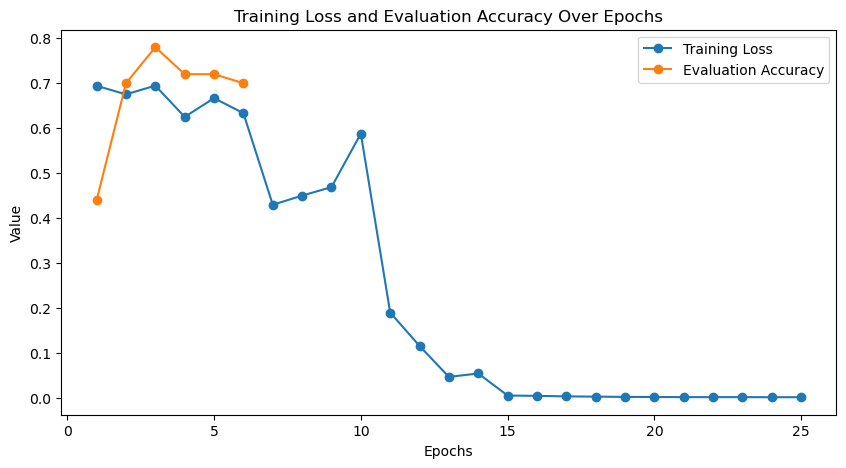

In [3]:
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
import matplotlib.pyplot as plt

# Load the IMDb dataset and limit the dataset size further
dataset = load_dataset("imdb")
train_dataset = dataset["train"].shuffle(seed=42).select([i for i in range(200)])  # 200 samples for training
test_dataset = dataset["test"].shuffle(seed=42).select([i for i in range(50)])   # 50 samples for testing

# Load the pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load the smaller DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define the training arguments with further optimizations for 5 epochs
training_args = TrainingArguments(
    output_dir='./results',           # output directory
    num_train_epochs=5,               # set the number of epochs to 5
    per_device_train_batch_size=4,    # smaller batch size for training
    per_device_eval_batch_size=8,     # smaller batch size for evaluation
    warmup_steps=50,                  # reduced warmup steps
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',             # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",      # evaluation strategy during training
    save_strategy="epoch",            # save checkpoint every epoch
    load_best_model_at_end=True,      # option to load best model
)

# Define the compute_metrics function to calculate precision, recall, and F1
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Define the Trainer class
trainer = Trainer(
    model=model,                         # the model to train
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics      # add metrics function
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Print evaluation results
print("Evaluation results:", eval_results)

# Example new review
new_review = "The movie was fantastic, I loved it!"

# Tokenize the review
inputs = tokenizer(new_review, return_tensors="pt", padding=True, truncation=True)

# Make prediction
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1)

# Print prediction
print(f"Predicted sentiment: {'positive' if predicted_class == 1 else 'negative'}")

# Example visualization (training loss and evaluation accuracy over epochs)
train_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
eval_accuracies = [entry['eval_accuracy'] for entry in trainer.state.log_history if 'eval_accuracy' in entry]

# Plot the training loss and evaluation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Evaluation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Evaluation Accuracy Over Epochs')
plt.legend()
plt.show()

In [5]:
from transformers import TrainingArguments
import numpy as np

# Define parameter values to test
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [4, 8]
epochs = [3, 5]

# Function to train and evaluate with specific parameters
def train_and_evaluate(learning_rate, batch_size, num_epochs):
    # Define training arguments with current parameters
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        warmup_steps=50,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        learning_rate=learning_rate,
    )
    
    # Initialize Trainer with current arguments
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results

# Experiment and log results
results = []
for lr in learning_rates:
    for bs in batch_sizes:
        for epoch in epochs:
            print(f"Training with learning_rate={lr}, batch_size={bs}, epochs={epoch}")
            result = train_and_evaluate(lr, bs, epoch)
            results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'epochs': epoch,
                'accuracy': result['eval_accuracy'],
                'precision': result['eval_precision'],
                'recall': result['eval_recall'],
                'f1': result['eval_f1']
            })

# Display results for each combination
for result in results:
    print(result)


Training with learning_rate=2e-05, batch_size=4, epochs=3


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.127700,1.038759,0.700000,0.594595,1.000000,0.745763
2,0.026700,0.840402,0.760000,0.678571,0.863636,0.760000
3,0.002400,0.849024,0.780000,0.739130,0.772727,0.755556


Training with learning_rate=2e-05, batch_size=4, epochs=5


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000900,0.952994,0.800000,0.750000,0.818182,0.782609
2,0.262600,1.411010,0.780000,0.689655,0.909091,0.784314
3,0.000200,1.189175,0.840000,0.750000,0.954545,0.840000
4,0.000200,1.268171,0.760000,0.708333,0.772727,0.739130
5,0.000200,1.334535,0.780000,0.739130,0.772727,0.755556


Training with learning_rate=2e-05, batch_size=8, epochs=3


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000700,1.073071,0.800000,0.730769,0.863636,0.791667
2,0.000200,1.265937,0.800000,0.750000,0.818182,0.782609
3,0.000100,1.322749,0.820000,0.740741,0.909091,0.816327


Training with learning_rate=2e-05, batch_size=8, epochs=5


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000400,1.197745,0.840000,0.750000,0.954545,0.840000
2,0.000100,1.406943,0.820000,0.740741,0.909091,0.816327
3,0.000100,1.592071,0.800000,0.730769,0.863636,0.791667
4,0.000000,1.588044,0.800000,0.730769,0.863636,0.791667
5,0.000000,1.595326,0.800000,0.730769,0.863636,0.791667


Training with learning_rate=3e-05, batch_size=4, epochs=3


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000100,1.663740,0.760000,0.666667,0.909091,0.769231
2,0.000000,1.967308,0.760000,0.666667,0.909091,0.769231
3,0.000000,2.017208,0.740000,0.655172,0.863636,0.745098


Training with learning_rate=3e-05, batch_size=4, epochs=5


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.867342,0.760000,0.666667,0.909091,0.769231
2,0.000000,2.376941,0.760000,0.666667,0.909091,0.769231
3,0.000000,2.526985,0.740000,0.655172,0.863636,0.745098
4,0.000000,2.561316,0.740000,0.655172,0.863636,0.745098
5,0.000000,2.568681,0.740000,0.655172,0.863636,0.745098


Training with learning_rate=3e-05, batch_size=8, epochs=3


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,2.166668,0.760000,0.666667,0.909091,0.769231
2,0.000000,2.181260,0.800000,0.750000,0.818182,0.782609
3,0.000000,2.375885,0.780000,0.703704,0.863636,0.775510


Training with learning_rate=3e-05, batch_size=8, epochs=5


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,2.146494,0.740000,0.655172,0.863636,0.745098
2,0.000000,2.298550,0.780000,0.703704,0.863636,0.775510
3,0.000000,2.506252,0.780000,0.703704,0.863636,0.775510
4,0.000000,2.669790,0.740000,0.655172,0.863636,0.745098
5,0.000000,2.686384,0.740000,0.655172,0.863636,0.745098


Training with learning_rate=5e-05, batch_size=4, epochs=3


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,2.377660,0.760000,0.678571,0.863636,0.760000
2,0.000000,2.720128,0.760000,0.666667,0.909091,0.769231
3,0.000000,2.839174,0.760000,0.666667,0.909091,0.769231


Training with learning_rate=5e-05, batch_size=4, epochs=5


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,2.681449,0.760000,0.666667,0.909091,0.769231
2,0.000000,3.052604,0.760000,0.666667,0.909091,0.769231
3,0.000000,3.145264,0.760000,0.666667,0.909091,0.769231
4,0.000000,3.169387,0.760000,0.666667,0.909091,0.769231
5,0.000000,3.114825,0.760000,0.666667,0.909091,0.769231


Training with learning_rate=5e-05, batch_size=8, epochs=3


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,2.801169,0.760000,0.666667,0.909091,0.769231
2,0.000000,3.120998,0.760000,0.666667,0.909091,0.769231
3,0.000000,3.108331,0.760000,0.666667,0.909091,0.769231


Training with learning_rate=5e-05, batch_size=8, epochs=5


C:\Users\CYTech Student\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,2.882599,0.760000,0.666667,0.909091,0.769231
2,0.000000,3.109434,0.760000,0.666667,0.909091,0.769231
3,0.000000,3.093565,0.760000,0.666667,0.909091,0.769231
4,0.000000,3.112664,0.760000,0.666667,0.909091,0.769231
5,0.000000,3.123396,0.760000,0.666667,0.909091,0.769231


{'learning_rate': 2e-05, 'batch_size': 4, 'epochs': 3, 'accuracy': 0.76, 'precision': 0.6785714285714286, 'recall': 0.8636363636363636, 'f1': 0.76}
{'learning_rate': 2e-05, 'batch_size': 4, 'epochs': 5, 'accuracy': 0.8, 'precision': 0.75, 'recall': 0.8181818181818182, 'f1': 0.782608695652174}
{'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.8, 'precision': 0.7307692307692307, 'recall': 0.8636363636363636, 'f1': 0.7916666666666666}
{'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 5, 'accuracy': 0.84, 'precision': 0.75, 'recall': 0.9545454545454546, 'f1': 0.84}
{'learning_rate': 3e-05, 'batch_size': 4, 'epochs': 3, 'accuracy': 0.76, 'precision': 0.6666666666666666, 'recall': 0.9090909090909091, 'f1': 0.7692307692307693}
{'learning_rate': 3e-05, 'batch_size': 4, 'epochs': 5, 'accuracy': 0.76, 'precision': 0.6666666666666666, 'recall': 0.9090909090909091, 'f1': 0.7692307692307693}
{'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.76, 'precision': 0